In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

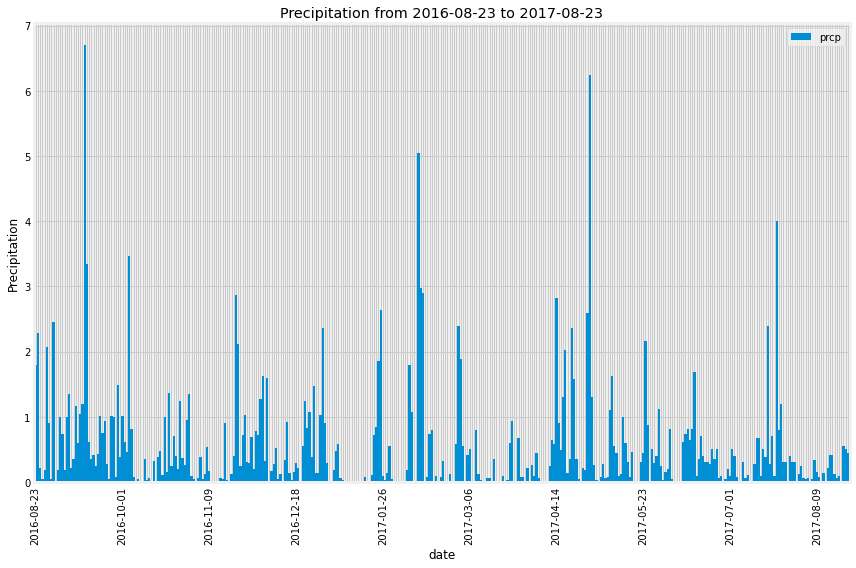

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastest_data_date=session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()[0]
one_year_ago=datetime.strptime(lastest_data_date,'%Y-%m-%d')-dt.timedelta(days=366)
#one_year_ago=one_year_ago.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
precipitation_12months=session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.date>one_year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df= pd.DataFrame(precipitation_12months,columns=['prcp','date'])
precipitation_df['date']=pd.to_datetime(precipitation_df['date'])
#precipitation_df.dropna(inplace=True)
precipitation_df.set_index('date',inplace=True)
# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df_plot = precipitation_df.resample('1D')[['prcp']].max()
ticklabels = ['']*len(precipitation_df_plot.index)
ticklabels[::39] = [item.strftime('%Y-%m-%d') for item in precipitation_df_plot.index[::39]]
ax = precipitation_df_plot.plot.bar(figsize=(12,8),width = 1,title=f'Precipitation from {one_year_ago+dt.timedelta(days=1):%Y-%m-%d} to {lastest_data_date}')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
#plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.ylabel('Precipitation')
plt.tight_layout()
plt.savefig('outputs/precipitation_last_12_months.png',bbox_inches="tight")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [28]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(Measurement.station).\
        distinct(Measurement.station).count()
print(f'The data set has {num_station} available stations')
session.query(Measurement.station).distinct(Measurement.station).all()

The data set has 9 available stations


c:\Users\datqu\anaconda3\envs\bootcamp\lib\site-packages\ipykernel_launcher.py:5: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  """


[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
(active_station,record)=session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()
print(f'Most active station is {active_station} with {record} records.')
session.query(Measurement.station,func.count(Measurement.station)).\
        group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

Most active station is USC00519281 with 2772 records.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
(active_station,min_tobs,max_tobs,avg_tobs)=session.query(Measurement.station,func.min(Measurement.tobs),
              func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                  filter(Measurement.station=='USC00519281').\
                      group_by(Measurement.station).first()
print(f'Most active station {active_station} has lowest tempt {min_tobs}F, highest temp {max_tobs}F, and avg temp {avg_tobs:.2f}F')

Most active station USC00519281 has lowest tempt 54.0F, highest temp 85.0F, and avg temp 71.66F


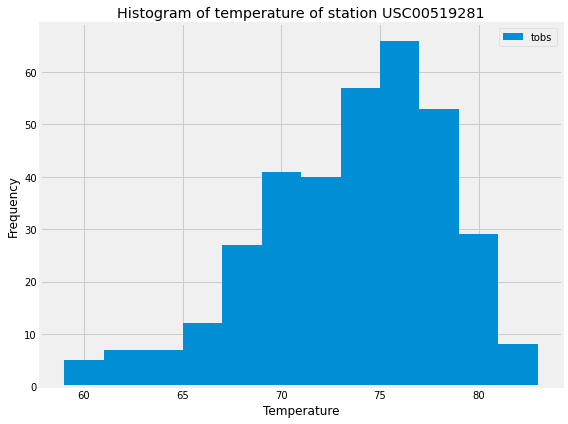

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_obs_station_id=session.query(Measurement.station,func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
            order_by(func.count(Measurement.tobs).desc()).first()[0]
temperature_obs= session.query(Measurement.tobs).\
    filter(Measurement.date>one_year_ago).\
    filter(Measurement.station==highest_temp_obs_station_id).all()
tobs_df=pd.DataFrame(temperature_obs,columns=['tobs'])
tobs_df.plot.hist(bins=12,title=f'Histogram of temperature of station {highest_temp_obs_station_id}',figsize=(8,6))
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig('outputs/histogram_temperature.png',bbox_inches="tight")

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
(tmin,tavg,tmax) = calc_temps('2016-01-01','2016-01-09')[0]
print(calc_temps('2016-01-01','2016-01-09'))

[(62.0, 70.38888888888889, 78.0)]


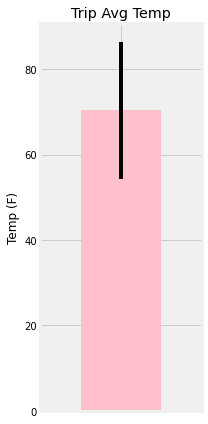

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_df =pd.DataFrame(calc_temps('2016-01-01','2016-01-09'),columns=['tmin','tavg','tmax'])
yerr =(temp_df.tmax -temp_df.tmin).to_numpy().T
temp_df['tavg'].plot.bar(yerr=yerr,title= 'Trip Avg Temp',figsize=(3,6),color='pink')
plt.ylabel('Temp (F)')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.savefig('outputs/Trip_Avg_temp.png',bbox_inches="tight")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station,func.sum(Measurement.prcp),
              Station.name,Station.latitude,Station.longitude,Station.elevation).\
        filter(Measurement.date >= '2016-01-01').filter(Measurement.date <= '2016-01-09').\
            filter(Station.station==Measurement.station).\
                group_by(Measurement.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 2.9400000000000004, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 0.97, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 0.56, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.22000000000000003, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00519397', 0.22, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.13, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = datetime.strptime('2016-01-01','%Y-%m-%d')
end_date= datetime.strptime('2016-01-09','%Y-%m-%d')
# Use the start and end date to create a range of dates
dates_range = [start_date + dt.timedelta(days=x) for x in range((end_date-start_date).days+1)]
# Stip off the year and save a list of %m-%d strings
dates_range_string = [datetime.strftime(dates_range[x],'%m-%d') for x in range((end_date-start_date).days+1)]
# Loop through the list of %m-%d strings and calculate the normals for each date
list_daily_normal =[]
for x in dates_range_string:
    list_daily_normal.append(daily_normals(x)[0])
list_daily_normal


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dates_range= [datetime.strftime(dates_range[x],'%Y-%m-%d') for x in range((end_date-start_date).days+1)]
daily_normals_df = pd.DataFrame(list_daily_normal,columns=['tmin','tavg','tmax'],index=dates_range)
daily_normals_df


,tmin,tavg,tmax
2016-01-01,62.0,69.153846,77.0
2016-01-02,60.0,69.396226,77.0
2016-01-03,62.0,68.909091,77.0
2016-01-04,58.0,70.000000,76.0
2016-01-05,56.0,67.964286,76.0
2016-01-06,61.0,68.964912,76.0
2016-01-07,57.0,68.543860,76.0
2016-01-08,57.0,67.160714,75.0
2016-01-09,58.0,67.929825,78.0


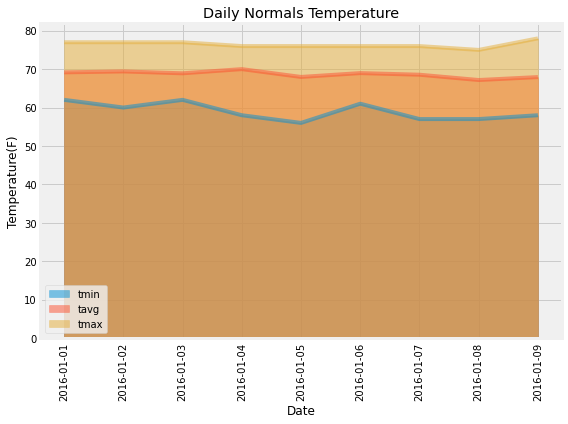

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False, figsize = (8,6),title='Daily Normals Temperature')
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Temperature(F)')
plt.tight_layout()
plt.savefig('outputs/daily_normals.png',bbox_inches="tight")